In [1]:
from scipy import stats 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Epydemix import
import sys 
sys.path.append("../")
from epydemix.population import Population
from epydemix.epimodel import EpiModel, stochastic_simulation
from epydemix.plotting import plot_quantiles, plot_selected_quantiles, plot_posterior, plot_posterior_2d
from epydemix.calibration import calibration_top_perc, calibration_abc_smc

# Calibration

Import population data:

In [2]:
population = Population() 
population.load_population(population_name="Indonesia", path_to_data="../epydemix_data/")

Import epidemiological data:

In [3]:
df_I = pd.read_csv("./data/data_I.csv")
df_incidence = pd.read_csv("./data/data_incidence.csv")

Define model and priors:

In [4]:
# create model 
model = EpiModel(compartments=["S", "I", "R"])
model.add_parameters({"bet": 0.02, "mu": 0.2})
model.add_transition(source="S", target="I", rate_name="bet", agent="I")
model.add_transition(source="I", target="R", rate_name="mu")

# initial conditions
S=population.Nk - np.ones(len(population.Nk))
I=np.ones(len(population.Nk))
R=np.zeros(len(population.Nk))

# simulation dates
steps = "daily"
start_date=df_I.date.values[0]
end_date=df_I.date.values[-1]
start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
simulation_dates = pd.date_range(start=start_date, end=end_date, freq="d").tolist()
model.compute_contact_reductions(population, simulation_dates)

# parameters
parameters = {"S": S, 
              "I": I, 
              "R": R, 
              "epimodel": model, 
              "dt": np.diff(simulation_dates)[0] / timedelta(days=1),
              "population": population, 
              "simulation_dates": simulation_dates}

# priors
priors = {"bet": stats.uniform(0.015, 0.025), "mu": stats.uniform(0.15, 0.25)}

## Top % Calibration

In [5]:
def post_processing_function(results, **parameters): 
    results.update({"data": results["I_total"]})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_I["I"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

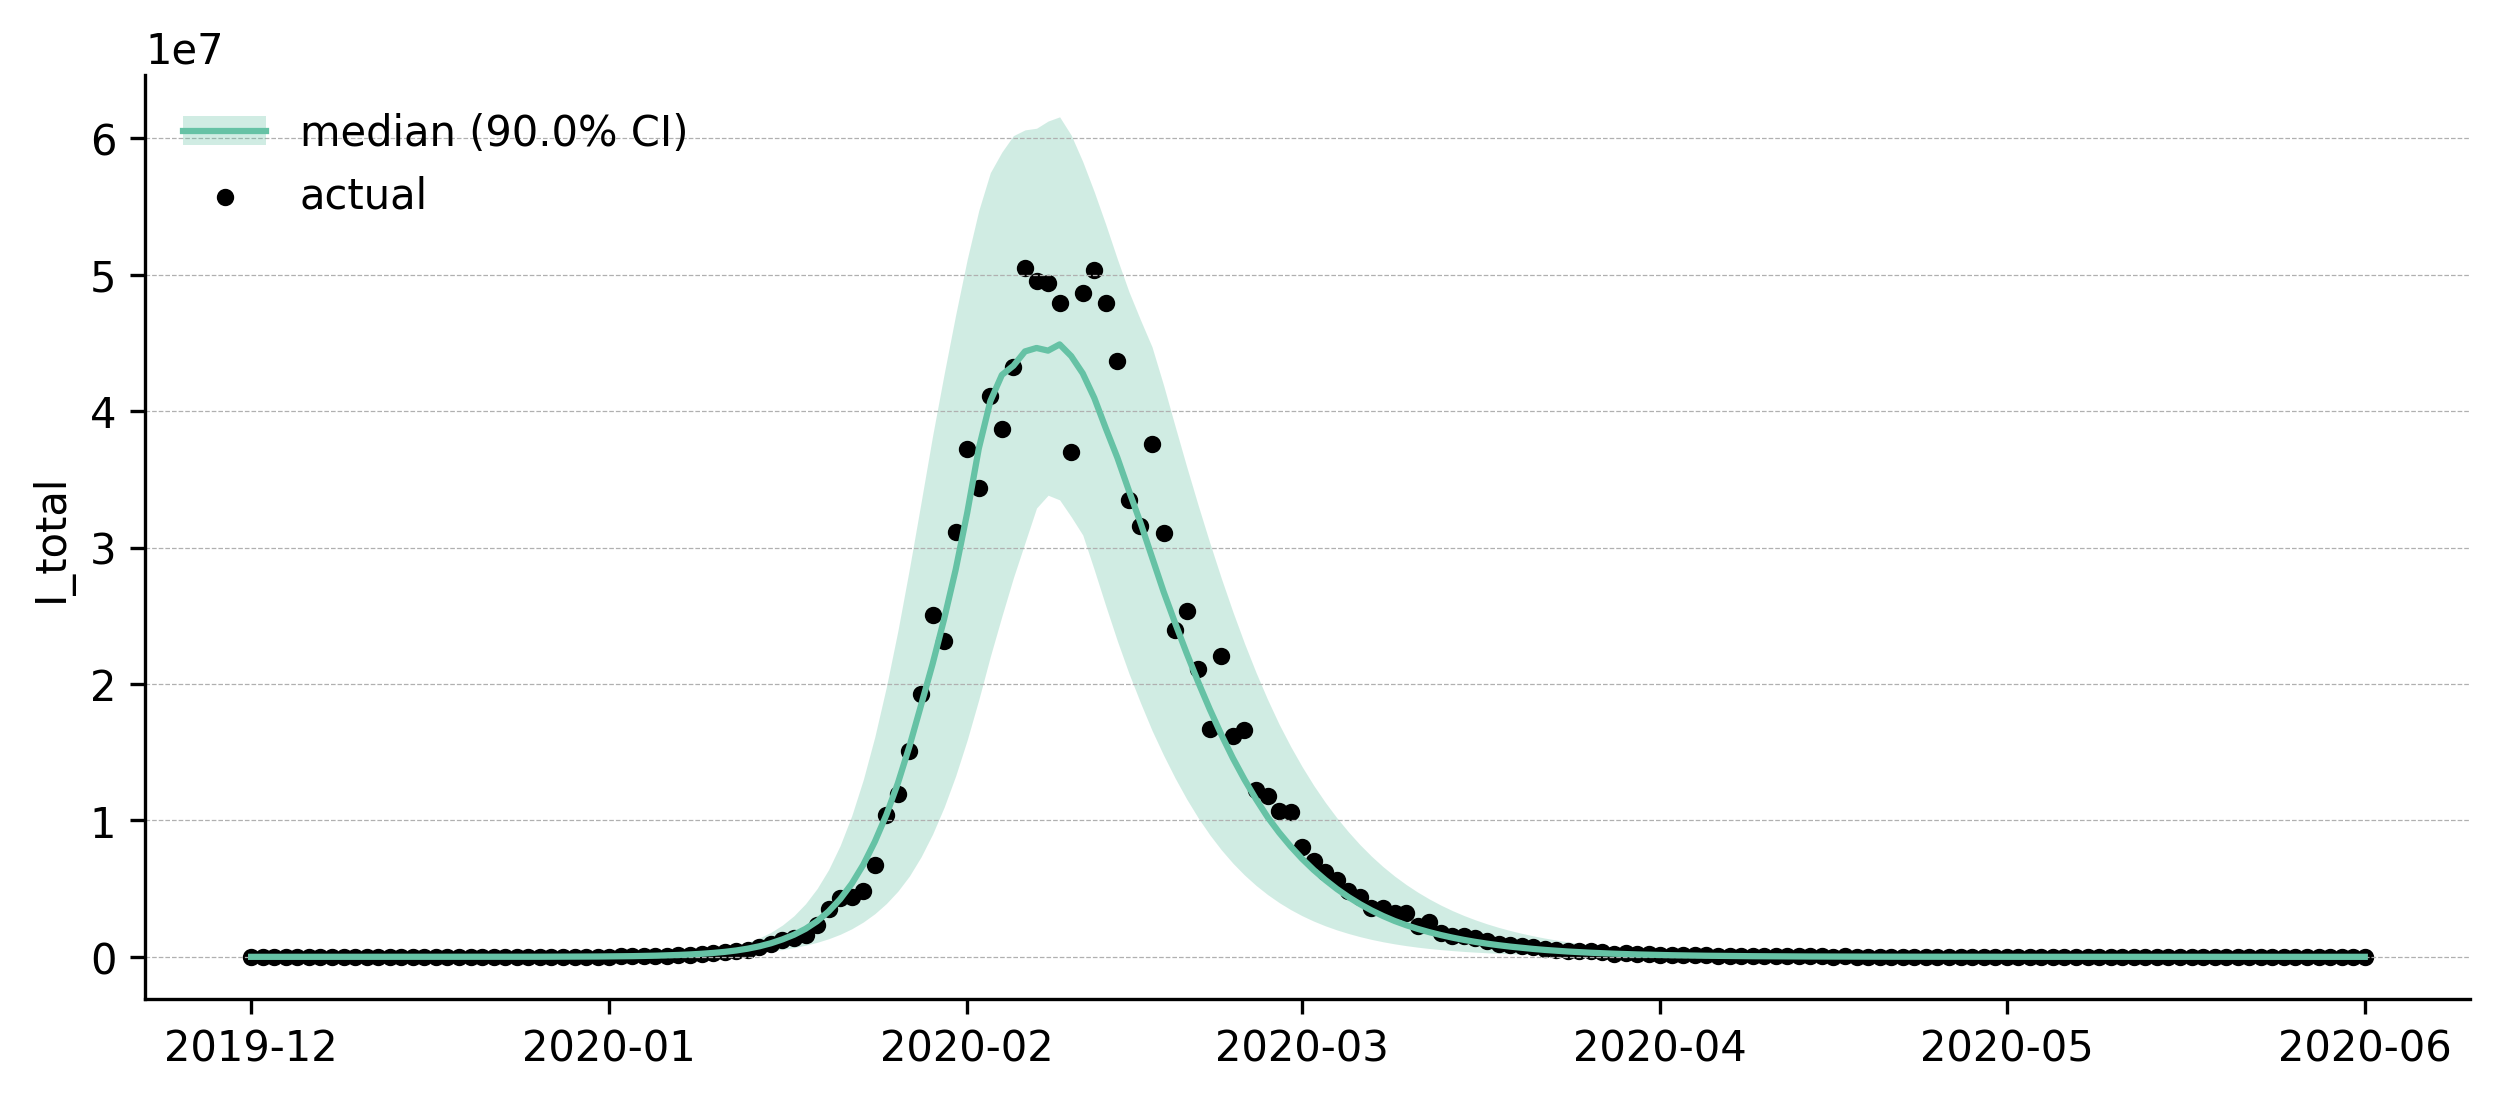

In [6]:
plot_selected_quantiles(results, ylabel="I_total")

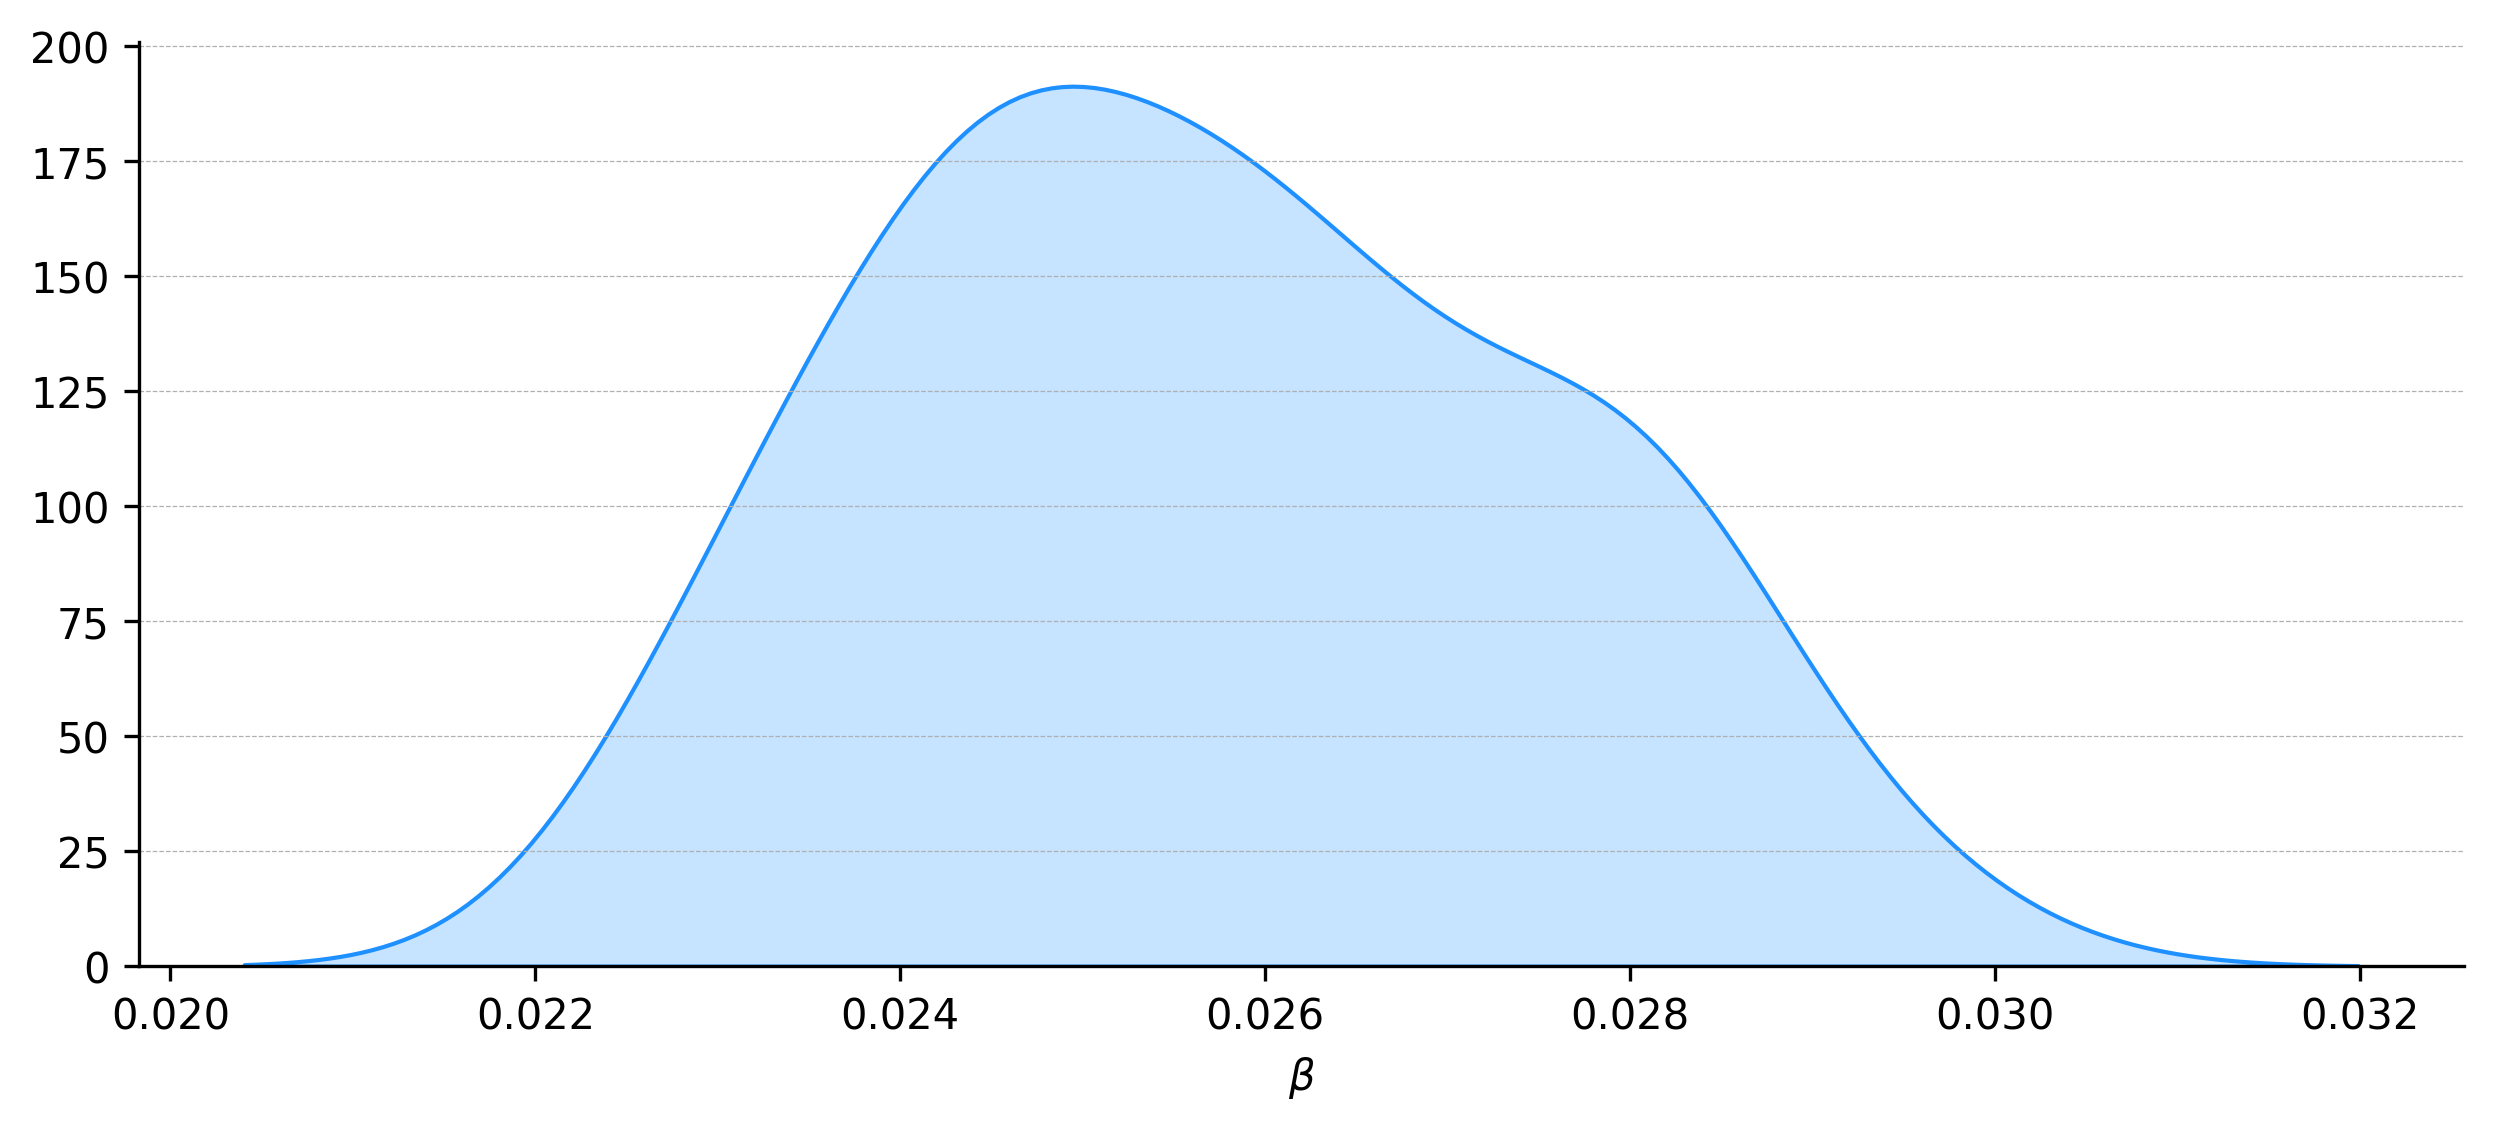

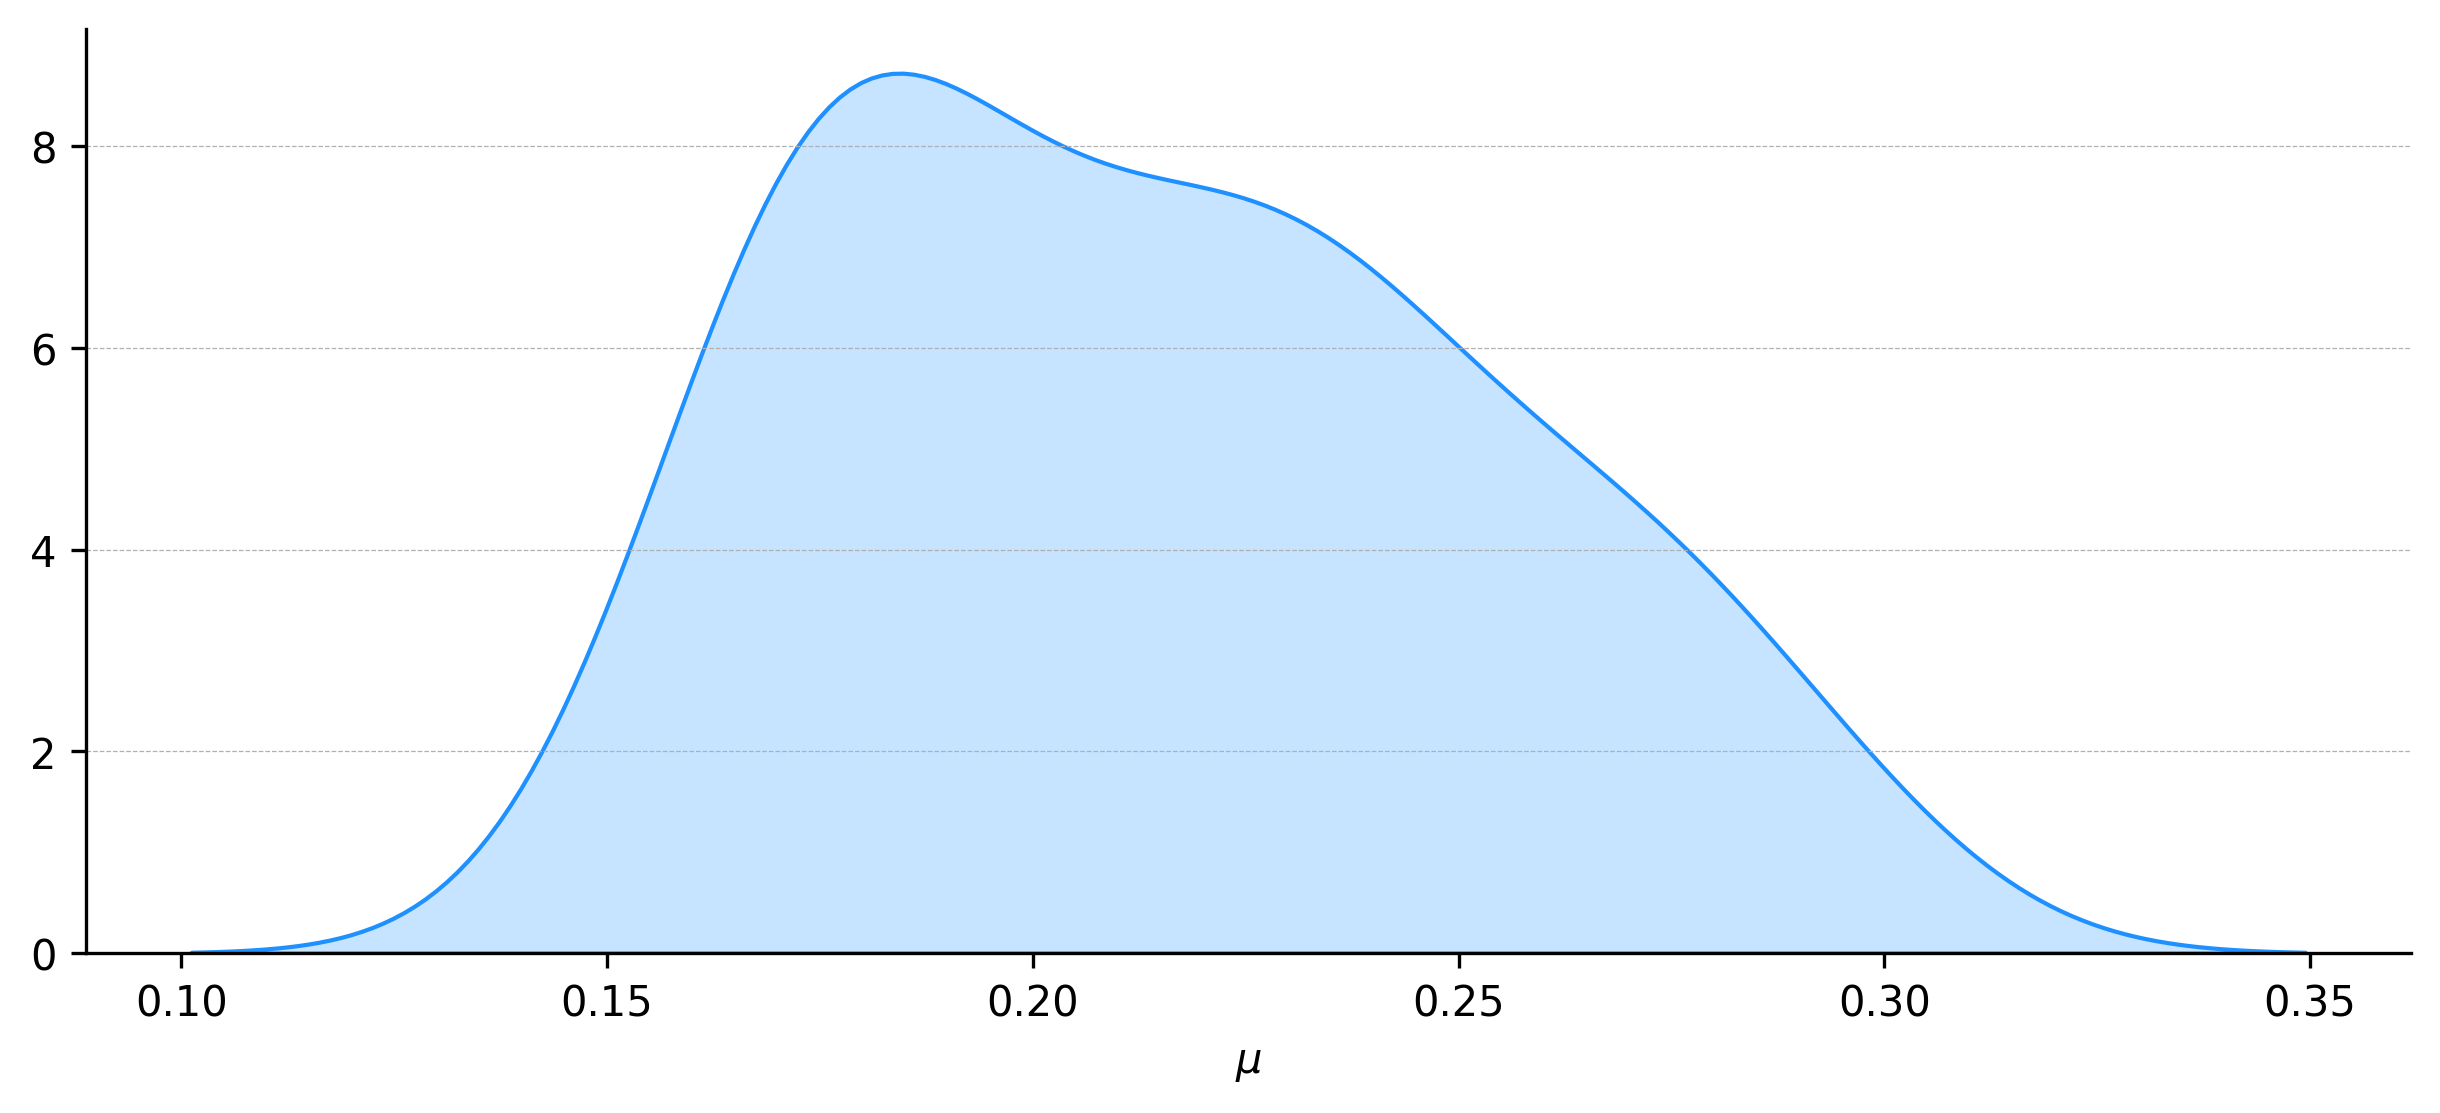

In [7]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

../epydemix/plotting.py:229: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.kdeplot(data=df_posterior, x=parameter_x, y=parameter_y, ax=ax, fill=True, palette=palette, **kwargs)


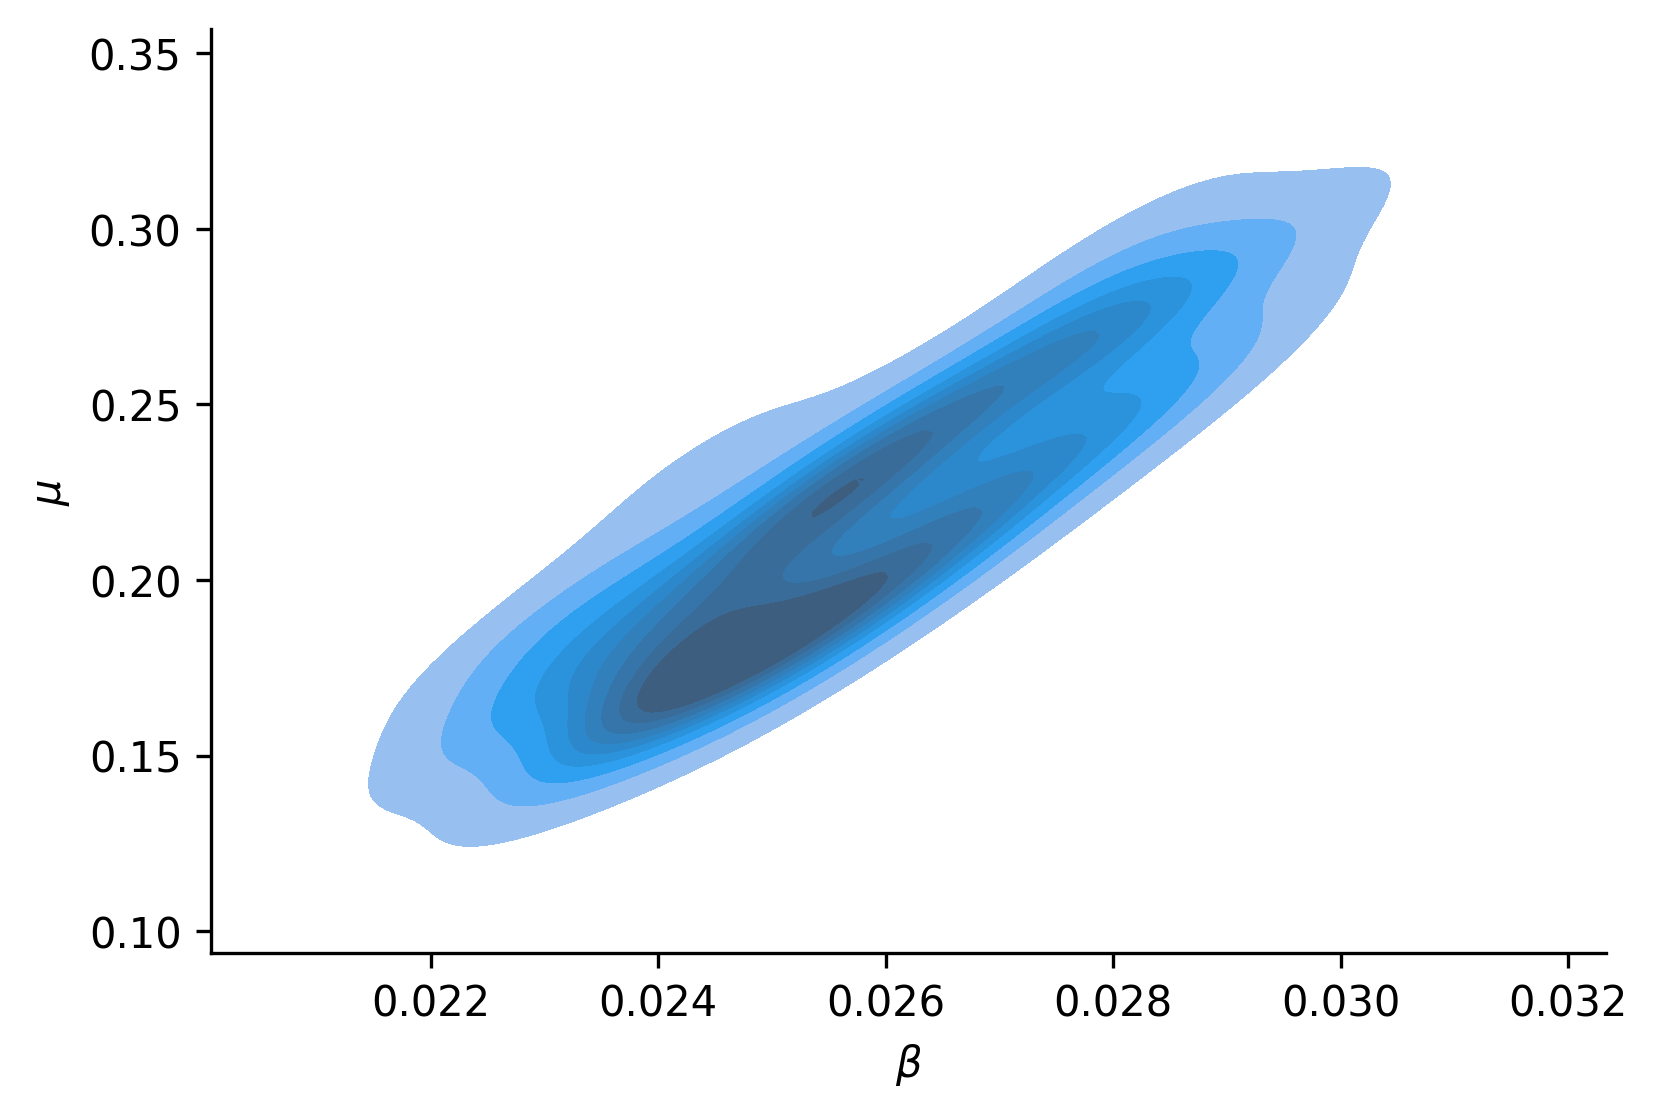

In [8]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

# Incidence Example

In [ ]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

results = calibration_top_perc(simulation_function=stochastic_simulation, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_incidence["incidence"].values},
                               top_perc=0.05,
                               Nsim=1000,
                               post_processing_function=post_processing_function)

In [ ]:
plot_selected_quantiles(results, ylabel="incidence")

In [ ]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

In [ ]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

## ABC-SMC

In [9]:
def post_processing_function(results, **parameters): 
    results.update({"data": np.concatenate(([0], (np.abs(np.diff(results["S_total"])))))})
    return results

results = calibration_abc_smc(simulation_function=stochastic_simulation, 
                              priors=priors, 
                              parameters=parameters, 
                              data={"data": df_incidence["incidence"].values}, 
                              post_processing_function=post_processing_function, 
                              population_size=50)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=1, start_time=2024-06-07 15:38:52>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 2.71277092e+06.
ABC INFO: Accepted: 50 / 106 = 4.7170e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 2.10157964e+06.
ABC INFO: Accepted: 50 / 120 = 4.1667e-01, ESS: 4.7227e+01.
ABC INFO: t: 2, eps: 1.33807127e+06.
ABC INFO: Accepted: 50 / 126 = 3.9683e-01, ESS: 4.9062e+01.
ABC INFO: t: 3, eps: 7.41544723e+05.
ABC INFO: Accepted: 50 / 94 = 5.3191e-01, ESS: 5.1547e+00.
ABC INFO: t: 4, eps: 6.65234518e+05.
ABC INFO: Accepted: 50 / 243 = 2.0576e-01, ESS: 4.2841e+01.
ABC INFO: t: 5, eps: 4.02052171e+05.
ABC INFO: Accepted: 50 / 250 = 2.0000e-01, ESS: 4.5315e+01.
ABC INFO: t: 6, eps: 3.59296702e+05.
ABC INFO: Accepted: 50 / 317 = 1.5773e-01, ESS: 3.8801e+01.
ABC INFO: t: 7, eps: 3.23712928e+05.
ABC INFO: Accepted: 50 / 458 = 1.0917e-01, ESS: 4.0145e+01.
ABC INFO: t: 8, eps: 2.94560042e+05.
ABC INFO: Accepted: 50 / 5

In [ ]:
plot_selected_quantiles(results, ylabel="incidence")

In [ ]:
plot_posterior(results, "bet", kind="kde", prior_range=False, xlabel="$\\beta$")
plot_posterior(results, "mu", kind="kde", prior_range=False, xlabel="$\\mu$")

In [ ]:
plot_posterior_2d(results, "bet", "mu", kind="kde", prior_range=False, xlabel="$\\beta$", ylabel="$\\mu$")

# Calibrating your own model

In [ ]:
from models.custom_models import my_stochastic_SIR

parameters = {
    'S': 273523000 - 10,
    'I': 10,
    'R': 0,
    'N': 273523000,
    'simulation_dates': simulation_dates,
    'dt': 1.0}

# priors
priors = {"bet": stats.uniform(0.15, 0.35), "mu": stats.uniform(0.15, 0.15)}

In [ ]:
results = calibration_top_perc(simulation_function=my_stochastic_SIR, 
                               parameters=parameters,
                               priors=priors, 
                               data={"data": df_incidence["incidence"].values},
                               top_perc=0.05,
                               Nsim=10000)

In [ ]:
plot_selected_quantiles(results, ylabel="incidence")

# Running Projections

In [ ]:
#results
# run projections

#iterations = 100

#start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
#simulation_dates = pd.date_range(start=start_date, end=end_date, freq="d").tolist()
#model.compute_contact_reductions(population, simulation_dates)
